# Text-to-Speech with Tacotron2 and Waveglow

This is an English female voice TTS demo using open source projects [NVIDIA/tacotron2](https://github.com/NVIDIA/tacotron2) and [NVIDIA/waveglow](https://github.com/NVIDIA/waveglow).

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).

## Install Tacotron2 and Waveglow

In [1]:
%tensorflow_version 1.x
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 9168aea
  !pip install -q librosa unidecode
  
import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

TensorFlow 1.x selected.
Previous HEAD position was 5bc2a53 README.md: reporting correct number after finding bug in inference time code
HEAD is now at 9168aea README.md: layout
     |████████████████████████████████| 245kB 6.7MB/s 


## Download pretrained models

In [2]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

tacotron2_pretrained_model = 'tacotron2_statedict.pt'
if not exists(tacotron2_pretrained_model):
  # download the Tacotron2 pretrained model
  download_from_google_drive('1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA', tacotron2_pretrained_model)
waveglow_pretrained_model = 'waveglow_old.pt'
if not exists(waveglow_pretrained_model):
  # download the Waveglow pretrained model  
  download_from_google_drive('1WsibBTsuRg_SF2Z6L6NFRTT-NjEy1oTx', waveglow_pretrained_model)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    781      0 --:--:-- --:--:-- --:--:--   781
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  107M    0  107M    0     0  51.3M      0 --:--:--  0:00:02 --:--:--  103M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1797      0 --:--:-- --:--:-- --:--:--  1789
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  644M    0  644M    0     0   147M      0 --:--:--  0:00:04 --:--:--  188M


## Initialize Tacotron2 and Waveglow

Following code is copied from https://github.com/NVIDIA/tacotron2/blob/master/inference.ipynb and updated for the Colab.

In [3]:
import IPython.display as ipd
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='viridis')

torch.set_grad_enabled(False)
        
# initialize Tacotron2 with the pretrained model
hparams = create_hparams()
hparams.sampling_rate = 22050
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval()#.half()

# initialize Waveglow with the pretrained model
# waveglow = torch.load(waveglow_pretrained_model)['model']
# WORKAROUND for: https://github.com/NVIDIA/tacotron2/issues/182
import json
from glow import WaveGlow
waveglow_config = json.load(open('%s/waveglow/config.json' % project_name))['waveglow_config']
waveglow = WaveGlow(**waveglow_config)
waveglow.load_state_dict(torch.load(waveglow_pretrained_model)['model'].state_dict())
_ = waveglow.cuda().eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

## Synthesize a text

Replace `TEXT` with your text if you want try out another text.

In [4]:
TEXT = "Waveglow is really awesome!"

Now convert the text into mel spectrogram using Tacotron2 and plot it:

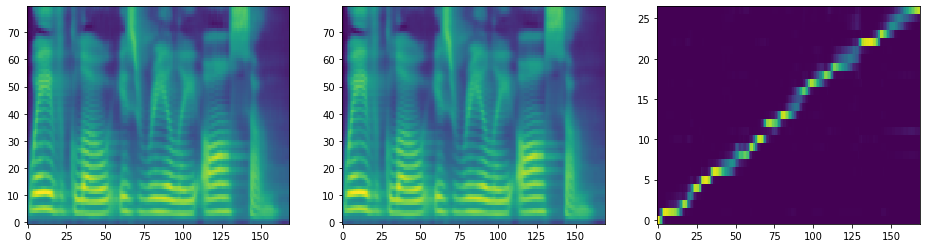

In [5]:
sequence = np.array(text_to_sequence(TEXT, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).long()
sequence = sequence.cuda()

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

Finally, we can convert the generated mel spectrogram into an audio:

In [6]:
audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [7]:
# remove waveglow bias
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)